In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
BATCH_SIZE = 256

In [57]:
file_name_initials = 'wheat_30_var_2_species'
file_name = file_name_initials+".csv"

def dir(file_name):
    return '../data/'+file_name

In [58]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 2
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [59]:
def dataset_file_name(file_name):
    name = "./dataset/"+str(file_name)
    if FILT != 0:
        name+="_FILTER_"+str(FILTER)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)+"_DERIVATIVE_"+str(DERIVATIVE)
    return name

In [60]:
def load_dataset(file_name):
    DATASET_FILE_NAME = dataset_file_name(file_name)
    X_train = np.load(DATASET_FILE_NAME+"_train_dataset.npy")
    y_train = np.load(DATASET_FILE_NAME+"_train_dataset_label.npy")
    X_test = np.load(DATASET_FILE_NAME+"_test_dataset.npy")
    y_test = np.load(DATASET_FILE_NAME+"_test_dataset_label.npy")
    
    return (X_train, y_train, X_test, y_test)

In [61]:
(X_train, y_train, X_test, y_test) = load_dataset(file_name_initials)

In [62]:
y_set = set(np.concatenate((y_train, y_test), axis =0))

In [63]:
NUM_OF_CLASSES = len(y_set)

In [64]:
NUM_OF_CLASSES

2

In [65]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(48384, 147, 1)
(12096, 147, 1)


In [66]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D
from keras.layers import LeakyReLU, Dropout

In [67]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape, activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=64, kernel_size=5, activation='LeakyReLU'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [68]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 143, 32)           192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 28, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)              

In [70]:
train_eva = []
test_eva = []

In [71]:
history_dataframe = pd.DataFrame() 

In [72]:
from IPython.display import clear_output

for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True, validation_split = 0.33)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
127/127 - 27s - loss: 0.6764 - accuracy: 0.5588 - val_loss: 0.6100 - val_accuracy: 0.6993 - 27s/epoch - 210ms/step
for training
1512/1512 [==============================] - 28s 18ms/step - loss: 0.6102 - accuracy: 0.6981
for testing
378/378 [==============================] - 9s 22ms/step - loss: 0.6072 - accuracy: 0.7020

Epoch:  2
127/127 - 18s - loss: 0.6150 - accuracy: 0.6677 - val_loss: 0.6028 - val_accuracy: 0.6802 - 18s/epoch - 143ms/step
for training
1512/1512 [==============================] - 24s 16ms/step - loss: 0.6034 - accuracy: 0.6775
for testing
378/378 [==============================] - 6s 15ms/step - loss: 0.5974 - accuracy: 0.6803

Epoch:  3
127/127 - 16s - loss: 0.5990 - accuracy: 0.6837 - val_loss: 0.5772 - val_accuracy: 0.7076 - 16s/epoch - 124ms/step
for training
1512/1512 [==============================] - 23s 15ms/step - loss: 0.5770 - accuracy: 0.7071
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.5713 - accuracy: 0.711

1512/1512 [==============================] - 19s 13ms/step - loss: 0.3917 - accuracy: 0.8235
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.3967 - accuracy: 0.8197

Epoch:  26
127/127 - 13s - loss: 0.4316 - accuracy: 0.8011 - val_loss: 0.3419 - val_accuracy: 0.8548 - 13s/epoch - 104ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.3436 - accuracy: 0.8535
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.3460 - accuracy: 0.8523

Epoch:  27
127/127 - 13s - loss: 0.3923 - accuracy: 0.8245 - val_loss: 0.3161 - val_accuracy: 0.8644 - 13s/epoch - 106ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.3174 - accuracy: 0.8624
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.3175 - accuracy: 0.8601

Epoch:  28
127/127 - 13s - loss: 0.4020 - accuracy: 0.8177 - val_loss: 0.4029 - val_accuracy: 0.8091 - 13s/epoch - 105ms/step
for trai

378/378 [==============================] - 5s 13ms/step - loss: 0.2640 - accuracy: 0.8840

Epoch:  50
127/127 - 14s - loss: 0.3302 - accuracy: 0.8534 - val_loss: 0.2940 - val_accuracy: 0.8692 - 14s/epoch - 107ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.2927 - accuracy: 0.8708
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.2962 - accuracy: 0.8662

Epoch:  51
127/127 - 14s - loss: 0.3234 - accuracy: 0.8590 - val_loss: 0.2538 - val_accuracy: 0.8951 - 14s/epoch - 108ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.2532 - accuracy: 0.8950
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.2546 - accuracy: 0.8938

Epoch:  52
127/127 - 14s - loss: 0.3210 - accuracy: 0.8582 - val_loss: 0.2510 - val_accuracy: 0.9015 - 14s/epoch - 107ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.2508 - accuracy: 0.9009
for tes

for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.1899 - accuracy: 0.9249
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.1874 - accuracy: 0.9272

Epoch:  75
127/127 - 14s - loss: 0.2785 - accuracy: 0.8777 - val_loss: 0.1906 - val_accuracy: 0.9213 - 14s/epoch - 113ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.1897 - accuracy: 0.9224
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.1865 - accuracy: 0.9253

Epoch:  76
127/127 - 14s - loss: 0.2712 - accuracy: 0.8807 - val_loss: 0.2091 - val_accuracy: 0.9151 - 14s/epoch - 110ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.2087 - accuracy: 0.9147
for testing
378/378 [==============================] - 5s 13ms/step - loss: 0.2059 - accuracy: 0.9172

Epoch:  77
127/127 - 22s - loss: 0.2662 - accuracy: 0.8844 - val_loss: 0.2149 - val_accuracy: 0.9133 - 22s/epoch - 170ms/

378/378 [==============================] - 3s 8ms/step - loss: 0.1727 - accuracy: 0.9326

Epoch:  99
127/127 - 10s - loss: 0.2529 - accuracy: 0.8910 - val_loss: 0.1863 - val_accuracy: 0.9223 - 10s/epoch - 82ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1850 - accuracy: 0.9235
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.1814 - accuracy: 0.9272

Epoch:  100
127/127 - 11s - loss: 0.2416 - accuracy: 0.8953 - val_loss: 0.1794 - val_accuracy: 0.9262 - 11s/epoch - 84ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1781 - accuracy: 0.9268
for testing
378/378 [==============================] - 3s 9ms/step - loss: 0.1773 - accuracy: 0.9277

Epoch:  101
127/127 - 11s - loss: 0.2406 - accuracy: 0.8962 - val_loss: 0.1685 - val_accuracy: 0.9322 - 11s/epoch - 84ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1665 - accuracy: 0.9330
for testing
37

for training
1512/1512 [==============================] - 13s 8ms/step - loss: 0.1512 - accuracy: 0.9380
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.1511 - accuracy: 0.9380

Epoch:  124
127/127 - 11s - loss: 0.2220 - accuracy: 0.9052 - val_loss: 0.1688 - val_accuracy: 0.9304 - 11s/epoch - 85ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1654 - accuracy: 0.9330
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.1649 - accuracy: 0.9351

Epoch:  125
127/127 - 11s - loss: 0.2169 - accuracy: 0.9087 - val_loss: 0.1564 - val_accuracy: 0.9344 - 11s/epoch - 85ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1534 - accuracy: 0.9368
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.1527 - accuracy: 0.9383

Epoch:  126
127/127 - 11s - loss: 0.2157 - accuracy: 0.9063 - val_loss: 0.1479 - val_accuracy: 0.9425 - 11s/epoch - 84ms/step
f

378/378 [==============================] - 5s 14ms/step - loss: 0.1681 - accuracy: 0.9296

Epoch:  148
127/127 - 15s - loss: 0.2062 - accuracy: 0.9133 - val_loss: 0.1351 - val_accuracy: 0.9461 - 15s/epoch - 121ms/step
for training
1512/1512 [==============================] - 22s 14ms/step - loss: 0.1334 - accuracy: 0.9486
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.1320 - accuracy: 0.9491

Epoch:  149
127/127 - 16s - loss: 0.2055 - accuracy: 0.9141 - val_loss: 0.1678 - val_accuracy: 0.9324 - 16s/epoch - 126ms/step
for training
1512/1512 [==============================] - 23s 15ms/step - loss: 0.1654 - accuracy: 0.9344
for testing
378/378 [==============================] - 7s 18ms/step - loss: 0.1665 - accuracy: 0.9344

Epoch:  150
127/127 - 15s - loss: 0.2060 - accuracy: 0.9128 - val_loss: 0.1443 - val_accuracy: 0.9409 - 15s/epoch - 120ms/step
for training
1512/1512 [==============================] - 22s 15ms/step - loss: 0.1416 - accuracy: 0.9432
for 

for training
1512/1512 [==============================] - 26s 17ms/step - loss: 0.1420 - accuracy: 0.9418
for testing
378/378 [==============================] - 6s 17ms/step - loss: 0.1441 - accuracy: 0.9439

Epoch:  173
127/127 - 18s - loss: 0.1904 - accuracy: 0.9204 - val_loss: 0.1410 - val_accuracy: 0.9440 - 18s/epoch - 140ms/step
for training
1512/1512 [==============================] - 25s 16ms/step - loss: 0.1374 - accuracy: 0.9453
for testing
378/378 [==============================] - 7s 18ms/step - loss: 0.1388 - accuracy: 0.9468

Epoch:  174
127/127 - 18s - loss: 0.1871 - accuracy: 0.9212 - val_loss: 0.1298 - val_accuracy: 0.9543 - 18s/epoch - 141ms/step
for training
1512/1512 [==============================] - 25s 17ms/step - loss: 0.1259 - accuracy: 0.9563
for testing
378/378 [==============================] - 7s 18ms/step - loss: 0.1281 - accuracy: 0.9547

Epoch:  175
127/127 - 17s - loss: 0.1930 - accuracy: 0.9201 - val_loss: 0.1566 - val_accuracy: 0.9383 - 17s/epoch - 137

378/378 [==============================] - 4s 12ms/step - loss: 0.1121 - accuracy: 0.9604

Epoch:  197
127/127 - 13s - loss: 0.1826 - accuracy: 0.9232 - val_loss: 0.1170 - val_accuracy: 0.9564 - 13s/epoch - 100ms/step
for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1143 - accuracy: 0.9581
for testing
378/378 [==============================] - 3s 9ms/step - loss: 0.1164 - accuracy: 0.9576

Epoch:  198
127/127 - 12s - loss: 0.1769 - accuracy: 0.9260 - val_loss: 0.1210 - val_accuracy: 0.9525 - 12s/epoch - 91ms/step
for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1160 - accuracy: 0.9566
for testing
378/378 [==============================] - 4s 11ms/step - loss: 0.1202 - accuracy: 0.9552

Epoch:  199
127/127 - 13s - loss: 0.1769 - accuracy: 0.9253 - val_loss: 0.1239 - val_accuracy: 0.9507 - 13s/epoch - 105ms/step
for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1206 - accuracy: 0.9523
for testi

for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.1324 - accuracy: 0.9448
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.1355 - accuracy: 0.9438

Epoch:  222
127/127 - 12s - loss: 0.1684 - accuracy: 0.9298 - val_loss: 0.1207 - val_accuracy: 0.9567 - 12s/epoch - 96ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.1162 - accuracy: 0.9604
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.1179 - accuracy: 0.9611

Epoch:  223
127/127 - 12s - loss: 0.1751 - accuracy: 0.9270 - val_loss: 0.1244 - val_accuracy: 0.9546 - 12s/epoch - 97ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.1199 - accuracy: 0.9567
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.1225 - accuracy: 0.9537

Epoch:  224
127/127 - 15s - loss: 0.1732 - accuracy: 0.9287 - val_loss: 0.1098 - val_accuracy: 0.9542 - 15s/epoch - 118ms/st

378/378 [==============================] - 4s 10ms/step - loss: 0.1024 - accuracy: 0.9598

Epoch:  246
127/127 - 13s - loss: 0.1535 - accuracy: 0.9384 - val_loss: 0.1112 - val_accuracy: 0.9572 - 13s/epoch - 105ms/step
for training
1512/1512 [==============================] - 17s 11ms/step - loss: 0.1032 - accuracy: 0.9615
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.1075 - accuracy: 0.9597

Epoch:  247
127/127 - 5471s - loss: 0.1639 - accuracy: 0.9327 - val_loss: 0.1038 - val_accuracy: 0.9597 - 5471s/epoch - 43s/step
for training
1512/1512 [==============================] - 19s 12ms/step - loss: 0.0975 - accuracy: 0.9643
for testing
378/378 [==============================] - 3s 9ms/step - loss: 0.1004 - accuracy: 0.9638

Epoch:  248
127/127 - 11s - loss: 0.1576 - accuracy: 0.9350 - val_loss: 0.1120 - val_accuracy: 0.9577 - 11s/epoch - 90ms/step
for training
1512/1512 [==============================] - 17s 11ms/step - loss: 0.1056 - accuracy: 0.9596
for 

for training
1512/1512 [==============================] - 16s 10ms/step - loss: 0.0974 - accuracy: 0.9626
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.1014 - accuracy: 0.9618

Epoch:  271
127/127 - 14s - loss: 0.1587 - accuracy: 0.9353 - val_loss: 0.1094 - val_accuracy: 0.9570 - 14s/epoch - 107ms/step
for training
1512/1512 [==============================] - 17s 11ms/step - loss: 0.1007 - accuracy: 0.9626
for testing
378/378 [==============================] - 4s 11ms/step - loss: 0.1041 - accuracy: 0.9600

Epoch:  272
127/127 - 15s - loss: 0.1489 - accuracy: 0.9391 - val_loss: 0.0945 - val_accuracy: 0.9644 - 15s/epoch - 115ms/step
for training
1512/1512 [==============================] - 16s 11ms/step - loss: 0.0886 - accuracy: 0.9679
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.0916 - accuracy: 0.9667

Epoch:  273
127/127 - 13s - loss: 0.1530 - accuracy: 0.9356 - val_loss: 0.1022 - val_accuracy: 0.9637 - 13s/epoch - 104

378/378 [==============================] - 12s 32ms/step - loss: 0.0969 - accuracy: 0.9653

Epoch:  295
127/127 - 32s - loss: 0.1447 - accuracy: 0.9410 - val_loss: 0.0939 - val_accuracy: 0.9633 - 32s/epoch - 254ms/step
for training
1512/1512 [==============================] - 43s 28ms/step - loss: 0.0868 - accuracy: 0.9671
for testing
378/378 [==============================] - 10s 27ms/step - loss: 0.0942 - accuracy: 0.9641

Epoch:  296
127/127 - 34s - loss: 0.1471 - accuracy: 0.9393 - val_loss: 0.1031 - val_accuracy: 0.9605 - 34s/epoch - 264ms/step
for training
1512/1512 [==============================] - 41s 27ms/step - loss: 0.0959 - accuracy: 0.9651
for testing
378/378 [==============================] - 10s 25ms/step - loss: 0.0991 - accuracy: 0.9638

Epoch:  297
127/127 - 27s - loss: 0.1419 - accuracy: 0.9414 - val_loss: 0.0953 - val_accuracy: 0.9652 - 27s/epoch - 209ms/step
for training
1512/1512 [==============================] - 34s 23ms/step - loss: 0.0881 - accuracy: 0.9691
f

for training
1512/1512 [==============================] - 22s 14ms/step - loss: 0.0831 - accuracy: 0.9693
for testing
378/378 [==============================] - 4s 11ms/step - loss: 0.0882 - accuracy: 0.9673

Epoch:  320
127/127 - 17s - loss: 0.1458 - accuracy: 0.9419 - val_loss: 0.1084 - val_accuracy: 0.9574 - 17s/epoch - 133ms/step
for training
1512/1512 [==============================] - 18s 12ms/step - loss: 0.1014 - accuracy: 0.9605
for testing
378/378 [==============================] - 6s 15ms/step - loss: 0.1082 - accuracy: 0.9581

Epoch:  321
127/127 - 17s - loss: 0.1425 - accuracy: 0.9419 - val_loss: 0.0930 - val_accuracy: 0.9637 - 17s/epoch - 130ms/step
for training
1512/1512 [==============================] - 22s 15ms/step - loss: 0.0863 - accuracy: 0.9678
for testing
378/378 [==============================] - 9s 23ms/step - loss: 0.0913 - accuracy: 0.9667

Epoch:  322
127/127 - 19s - loss: 0.1379 - accuracy: 0.9429 - val_loss: 0.0946 - val_accuracy: 0.9643 - 19s/epoch - 151

378/378 [==============================] - 5s 14ms/step - loss: 0.0861 - accuracy: 0.9696

Epoch:  344
127/127 - 19s - loss: 0.1364 - accuracy: 0.9438 - val_loss: 0.0846 - val_accuracy: 0.9681 - 19s/epoch - 147ms/step
for training
1512/1512 [==============================] - 21s 14ms/step - loss: 0.0770 - accuracy: 0.9721
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.0837 - accuracy: 0.9698

Epoch:  345
127/127 - 17s - loss: 0.1340 - accuracy: 0.9462 - val_loss: 0.0826 - val_accuracy: 0.9688 - 17s/epoch - 134ms/step
for training
1512/1512 [==============================] - 19s 13ms/step - loss: 0.0747 - accuracy: 0.9732
for testing
378/378 [==============================] - 5s 14ms/step - loss: 0.0820 - accuracy: 0.9701

Epoch:  346
127/127 - 19s - loss: 0.1372 - accuracy: 0.9446 - val_loss: 0.1252 - val_accuracy: 0.9503 - 19s/epoch - 147ms/step
for training
1512/1512 [==============================] - 20s 13ms/step - loss: 0.1160 - accuracy: 0.9547
for 

for training
1512/1512 [==============================] - 44s 29ms/step - loss: 0.0755 - accuracy: 0.9732
for testing
378/378 [==============================] - 11s 28ms/step - loss: 0.0871 - accuracy: 0.9674

Epoch:  369
127/127 - 31s - loss: 0.1221 - accuracy: 0.9496 - val_loss: 0.0876 - val_accuracy: 0.9670 - 31s/epoch - 242ms/step
for training
1512/1512 [==============================] - 43s 28ms/step - loss: 0.0774 - accuracy: 0.9716
for testing
378/378 [==============================] - 12s 33ms/step - loss: 0.0865 - accuracy: 0.9684

Epoch:  370
127/127 - 33s - loss: 0.1254 - accuracy: 0.9494 - val_loss: 0.0768 - val_accuracy: 0.9707 - 33s/epoch - 260ms/step
for training
1512/1512 [==============================] - 43s 28ms/step - loss: 0.0677 - accuracy: 0.9759
for testing
378/378 [==============================] - 11s 28ms/step - loss: 0.0742 - accuracy: 0.9736

Epoch:  371
127/127 - 35s - loss: 0.1252 - accuracy: 0.9489 - val_loss: 0.1089 - val_accuracy: 0.9552 - 35s/epoch - 

378/378 [==============================] - 6s 15ms/step - loss: 0.0841 - accuracy: 0.9692

Epoch:  393
127/127 - 22s - loss: 0.1228 - accuracy: 0.9496 - val_loss: 0.0891 - val_accuracy: 0.9644 - 22s/epoch - 175ms/step
for training
1512/1512 [==============================] - 29s 19ms/step - loss: 0.0767 - accuracy: 0.9701
for testing
378/378 [==============================] - 6s 15ms/step - loss: 0.0843 - accuracy: 0.9659

Epoch:  394
127/127 - 26s - loss: 0.1216 - accuracy: 0.9500 - val_loss: 0.0963 - val_accuracy: 0.9641 - 26s/epoch - 205ms/step
for training
1512/1512 [==============================] - 26s 17ms/step - loss: 0.0857 - accuracy: 0.9692
for testing
378/378 [==============================] - 11s 28ms/step - loss: 0.0969 - accuracy: 0.9651

Epoch:  395
127/127 - 24s - loss: 0.1306 - accuracy: 0.9466 - val_loss: 0.0842 - val_accuracy: 0.9704 - 24s/epoch - 188ms/step
for training
1512/1512 [==============================] - 21s 14ms/step - loss: 0.0749 - accuracy: 0.9743
for

In [43]:
history_dataframe

,loss,accuracy,val_loss,val_accuracy
0,0.637602,0.623593,0.637929,0.642701
1,0.565123,0.713607,0.508909,0.757312
2,0.465765,0.778789,0.379702,0.825327
3,0.356911,0.843138,0.436299,0.783992
4,0.305732,0.865503,0.398115,0.814806
...,...,...,...,...
395,0.011241,0.995990,0.025941,0.991044
396,0.007844,0.997131,0.032335,0.989729
397,0.007574,0.997563,0.024096,0.992672
398,0.008305,0.996792,0.029363,0.990230


In [44]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [45]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

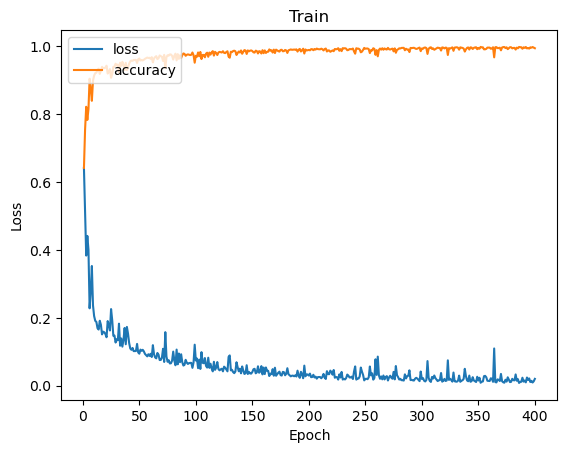

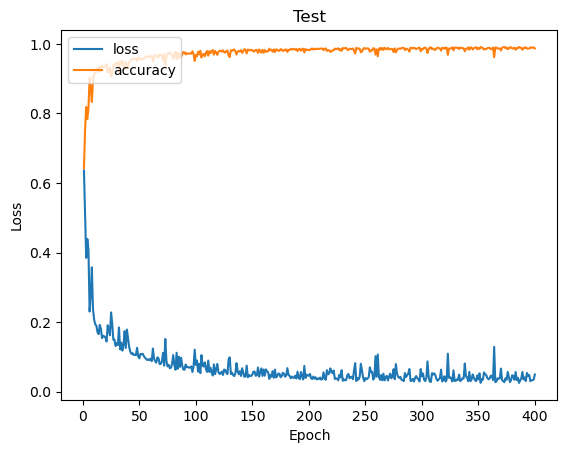

In [46]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])